<a name="pagetop"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>MetPy Declarative Plotting Interface</h1>
<h3>AMS Student Conference 2020 Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:300 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 350px;"></div>


## Overview:

* **Teaching:** 25 minutes

### Questions
1. How can satellite data be accessed with siphon?
1. How can maps of satellite, point observations, and model data be plotted using the declarative plotting interface?

### Table of Contents
1. <a href="#dataaccess">Accessing data with Siphon</a>
1. <a href="#plotting">Plotting the GOES-16 Imagery</a>
1. <a href="#plotobs">Plotting Surface/Point Observations</a>
1. <a href="#contour">Contour Plot of NAM Data</a>
1. <a href="#contourf">Contour Fill Plot of NAM Data</a>
1. <a href="barbplot">Wind Barb Plot using NAM Data
1. <a href="#combo">Combining Different Plots</a>

<a name="dataaccess"></a>
## Accessing data with Siphon

As we saw with the PlottingSatelliteData notebook, GOES 16/17 data is available via the Unidata THREDDS server and can be accessed with siphon. We make use of fstrings in order to provide date, region, and channel variables to the URL string.

In [1]:
from siphon.catalog import TDSCatalog
from datetime import datetime

In [2]:
# Create variables for URL generation
image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 8

# Create the URL to provide to siphon
data_url =  ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{image_date:%Y%m%d}/catalog.xml')

In [3]:
cat = TDSCatalog(data_url)

In [4]:
dataset = cat.datasets[1]
print(dataset)

OR_ABI-L2-CMIPC-M6C08_G16_s20200120506170_e20200120506170_c20200120506170.nc


In [5]:
ds = dataset.remote_access(use_xarray=True)
print(ds)

<xarray.Dataset>
Dimensions:               (x: 2500, y: 1500)
Coordinates:
    time                  datetime64[ns] ...
  * y                     (y) float32 128212.0 128156.0 ... 44324.0 44268.0
  * x                     (x) float32 -101332.0 -101276.0 ... 38556.0 38612.0
Data variables:
    Sectorized_CMI        (y, x) float32 ...
    fixedgrid_projection  int32 ...
Attributes:
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  8
    central_wavelength:          6.19
    abi_mode:                    6
    source_scene:                CONUS
    periodicity:                 5.0
    production_location:         RBU
    product_name:                ECONUS-020-B12-M6C08
    satellite_id:                GOES-16
    product_center_latitude:     30.08300267372796
    product_center_longitude:    -87.09695844824

<a name="plotting"></a>
## Plotting Satellite Data

To plot our data we'll be using MetPy's new declarative plotting functionality. You can write lots of matplotlib based code, but this interface greatly reduces the number of lines you need to write to get a great starting plot and then lets you customize it. The declarative plotting interface consists of three fundamental objects/concepts:

* **Plot** - This is the actual representation of the data and can be `ImagePlot`, `ContourPlot`, `Plot2D`, `FilledContourPlot` and `BarbPlot`.
* **Panel** - This is a single panel (i.e. coordinate system). Panels contain plots. Currently the `MapPanel` is the only panel type available.
* **Panel Container** - The container can hold multiple panels to make a multi-pane figure. Panel Containers can be thought of as the whole figure object in matplotlib.

So containers have panels which have plots. It takes a second to get that straight in your mind, but it makes setting up complex figures very simple.

For this plot we need a single panel and we want to plot the satellite image, so we'll use the `ImagePlot`.

In [6]:
import metpy.plots as mpplots

Let's start out with the smallest element, the plot, and build up to the largest, the panel container.

First, we'll make the `ImagePlot`:

In [7]:
img = mpplots.ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'

Next, we'll make the panel that our image will go into, the `MapPanel` object and add the image to the plots on the panel.

In [8]:
panel = mpplots.MapPanel()
panel.plots = [img]

Finally, we make the `PanelContainer` and add the panel to its container. Remember that since we can have multiple plots on a panel and multiple panels on a plot, we use lists. In this case is just happens to be a list of length 1.

In [9]:
pc = mpplots.PanelContainer()
pc.panels = [panel]

Unlike working with matplotlib directly in the notebooks, this figure hasn't actually been rendered yet. Calling the `show` method of the panel container builds up everything, renders, and shows it to us.

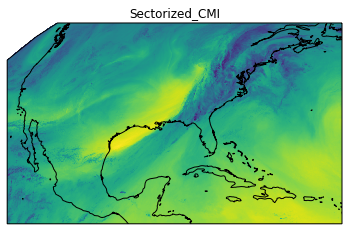

In [10]:
pc.show()

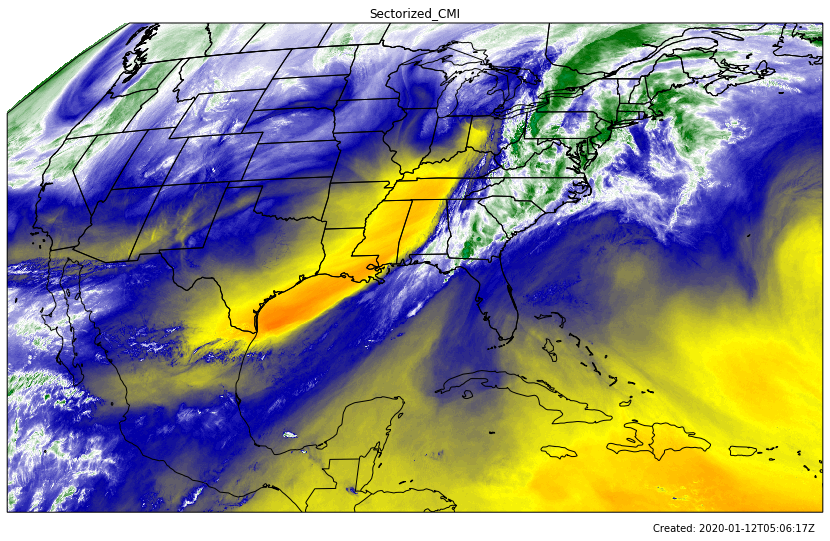

In [11]:
# Make the image plot
img = mpplots.ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'WVCIMSS_r'
img.image_range = (195, 265)

# Make the map panel and add the image to it
panel = mpplots.MapPanel()
panel.layers = ['coastline', 'borders', 'states']
panel.plots = [img]

# Make the panel container and add the panel to it
pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size=(15, 9)

# Add a timestamp
start_time = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
mpplots.add_timestamp(panel.ax, time=start_time)

# Show the plot
pc.show()

---

<a name="plotobs"></a>
### Plotting Surface Data using `PlotObs`

#### Determine which time to use, download the file, and parse the METARs
Data is from the [Unidata Thredds Test Server](https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html) which includes data from thirty days in the past to current observations

Another data source is the [Iowa State ASOS Archive](https://mesonet.agron.iastate.edu/request/download.phtml), although there is pre-processing neccessary to determine sky cover and weather symbols

In [12]:
from metpy.io import metar
from datetime import timedelta

# Use siphon to read in a METAR text file from the Unidata Thredds server
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

# Load in the latest hour's data
metar_ds = cat.datasets.filter_time_nearest(datetime.utcnow())

# Download the file
metar_ds.download()

# Parse the text file and create a Pandas dataframe
sfc_data = metar.parse_metar_file(metar_ds.name)

Next, we want to make sure we convert the temperature and dewpoint from degrees Celsius to degrees Fahrenheit

In [13]:
from metpy.units import units

sfc_data['air_temperature']  = (sfc_data['air_temperature'].values * units(sfc_data.units['air_temperature'])).to('degF')
sfc_data['dew_point_temperature'] = (sfc_data['dew_point_temperature'].values * units(sfc_data.units['dew_point_temperature'])).to('degF')

Now we setup our `PlotObs` object

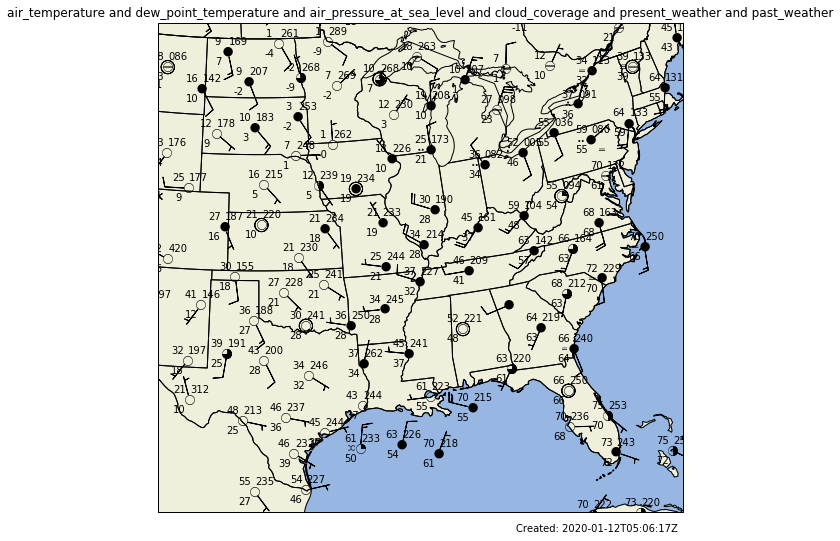

In [14]:
import warnings
warnings.filterwarnings("ignore")

obs = mpplots.PlotObs()
obs.data = sfc_data
obs.level = None
obs.fields = ['air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level', 'cloud_coverage', 'present_weather', 'past_weather']
obs.locations = ['NW', 'SW', 'NE', 'C', 'W', 'SE']
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover',
               'current_weather', 'current_weather']
obs.vector_field = ('eastward_wind', 'northward_wind')
obs.reduce_points = 2

# Setup the MapPanel
panel = mpplots.MapPanel()
panel.layers = ['coastline', 'borders', 'states', 'land', 'ocean']
panel.area = 'centus'
panel.projection = 'lcc'
panel.plots = [obs]
#panel.title = 'Surface Observations'

pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size=(15, 9)
mpplots.add_timestamp(panel.ax, time=start_time)
pc.show()

Plot upper level data using test data - the test data was pulled from the [Iowa State upper-air archive](https://mesonet.agron.iastate.edu/archive/raob/) which also requires preprocessing to add lats/lons. For now, we will use the test data from MetPy

In [15]:
import pandas as pd
from metpy.cbook import get_test_data

data = pd.read_csv(get_test_data('UPA_obs.csv', as_file_obj=False))

Let's see what is in the dataframe

In [16]:
data

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind,latitude,longitude
0,500.0,5377.0,-28.7,-39.8,316.0,75.0,1M1,1993-03-14,52.099378,-53.950485,NaN,NaN
1,300.0,8859.0,-47.9,NaN,304.0,96.0,1M1,1993-03-14,79.587607,-53.682519,NaN,NaN
2,500.0,5110.0,-43.5,-54.5,310.0,23.0,CWPL,1993-03-14,17.619022,-14.784115,51.466667,-90.2
3,300.0,8420.0,-53.9,-62.9,300.0,27.0,CWPL,1993-03-14,23.382686,-13.500000,51.466667,-90.2
4,500.0,5470.0,-13.7,-14.1,215.0,96.0,CWQI,1993-03-14,55.063338,78.638596,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
216,300.0,8852.0,-51.4,NaN,49.0,48.0,KYAK,1993-03-14,-36.226060,-31.490833,NaN,NaN
217,500.0,5220.0,-23.7,-25.3,185.0,54.0,KYMW,1993-03-14,4.706410,53.794514,NaN,NaN
218,300.0,8829.0,-42.9,-46.9,195.0,92.0,KYMW,1993-03-14,23.811352,88.865176,NaN,NaN
219,500.0,5379.0,-30.1,-38.1,355.0,19.0,KYXY,1993-03-14,1.655959,-18.927699,NaN,NaN


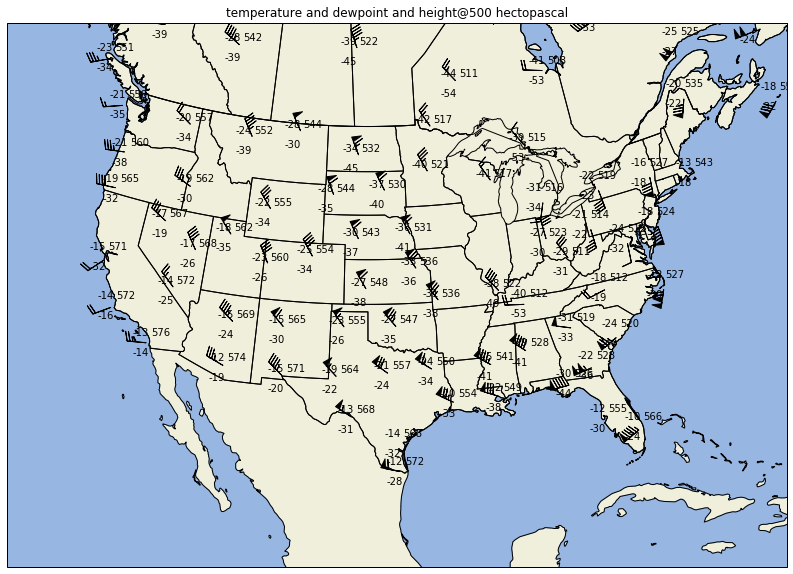

In [17]:
# Plotting the Observations
obs = mpplots.PlotObs()
obs.data = data
obs.time = datetime(1993, 3, 14, 0)
obs.level = 500 * units.hPa
obs.fields = ['temperature', 'dewpoint', 'height']
obs.locations = ['NW', 'SW', 'NE']
obs.formats = [None, None, lambda v: format(v, '.0f')[:3]]
obs.vector_field = ('u_wind', 'v_wind')
obs.reduce_points = 0

# Add map features for the particular panel
panel = mpplots.MapPanel()
panel.layout = (1, 1, 1)
panel.area = (-124, -72, 20, 53)
panel.projection = 'lcc'
panel.layers = ['coastline', 'borders', 'states', 'land', 'ocean']
panel.plots = [obs]

# Collecting panels for complete figure
pc = mpplots.PanelContainer()
pc.size = (15, 10)
pc.panels = [panel]

# Showing the results
pc.show()

---
<a name="contour"></a>
### Model data can also be easily plotted using `ContourPlot`

Read in most recent NAM data from the Unidata Thredds Server
Other model data can be found using the following website https://thredds.ucar.edu/thredds/catalog.html

In [18]:
cat_string = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/NAM/CONUS_12km/latest.xml'
cat = TDSCatalog(cat_string)
model_ds = cat.datasets[0].remote_access(use_xarray=True).metpy.parse_cf()

We don't want ALL the times from the model, so let's grab the first 10

In [19]:
model_ds = model_ds.sel(time = model_ds.time[0:10])

Here is a list of what variables are within the dataset

In [20]:
sorted(list(model_ds.variables))

['Absolute_vorticity_isobaric',
 'Best_4_layer_Lifted_Index_pressure_difference_layer',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Rain_surface',
 'Categorical_Snow_surface',
 'Composite_reflectivity_entire_atmosphere_single_layer',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_3_Hour_Accumulation',
 'Dewpoint_temperature_height_above_ground',
 'Geopotential_height_isobaric',
 'Geopotential_height_zeroDegC_isotherm',
 'LambertConformal_Projection',
 'MSLP_Eta_model_reduction_msl',
 'Maximum_temperature_height_above_ground',
 'Minimum_temperature_height_above_ground',
 'Parcel_lifted_index_to_500_hPa_pressure_difference_layer',
 'Percent_of_Frozen_Precipitation_surface_3_Hour_Accumulation',
 'Precipitable_water_entire_atmosphere_single_layer',
 'Pressur

Convert mean sea-Level pressure from pascals to hecopascals and temperature to degrees Fahrenheit

In [21]:
model_ds['Pressure_reduced_to_MSL_msl'].metpy.convert_units('hPa')
model_ds['Temperature_height_above_ground'].metpy.convert_units('degF')

Smooth the MSLP contours

In [22]:
from scipy.ndimage import gaussian_filter

# Smooth contour for MSLP
model_ds['Pressure_reduced_to_MSL_msl'] = (['time', 'y','x'], gaussian_filter(model_ds['Pressure_reduced_to_MSL_msl'], sigma=3.0))

# Smooth contour for surface temperature
model_ds['Temperature_height_above_ground'] = (['time', 'height_above_ground1','y','x'], gaussian_filter(model_ds['Temperature_height_above_ground'], sigma=3.0))

`ContourPlot` can be used to plot data from xarray datasets

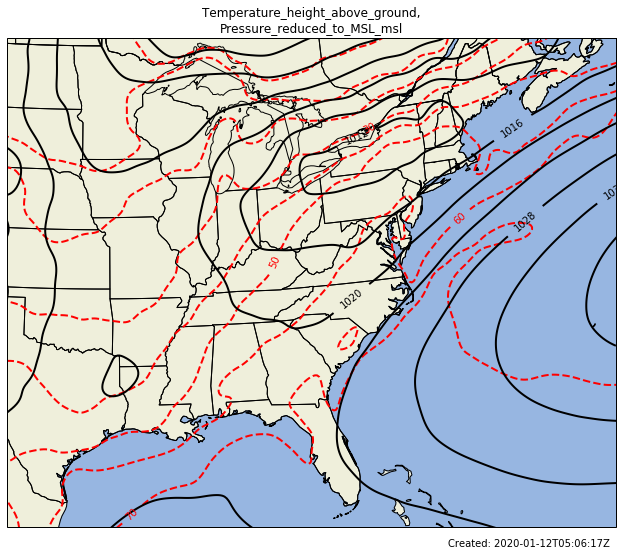

In [23]:
# Setup the ContourPlot, setting the desired variable to plot
contour_mslp = mpplots.ContourPlot()
contour_mslp.data = model_ds
contour_mslp.field = 'Pressure_reduced_to_MSL_msl' # Variable within the xarray dataset that will be plotted
contour_mslp.time = datetime.utcnow()
contour_mslp.level = None
contour_mslp.linecolor = 'black'
contour_mslp.clabels = True
contour_mslp.contours = list(range(900, 1100, 4)) # Contour intervals

# Setup another ContourPlot for temperature (in degrees Fahrenheit)
contour_temp = mpplots.ContourPlot()
contour_temp.data = model_ds
contour_temp.field = 'Temperature_height_above_ground'
contour_temp.time = datetime.utcnow()
contour_temp.linecolor = 'red'
contour_temp.linestyle = 'dashed'
contour_temp.clabels = True
contour_temp.contours = list(range(-50, 100, 10)) # Contour intervals

# Plot the east coast 
panel = mpplots.MapPanel()
panel.area = 'east'
panel.layers = ['coastline', 'borders', 'states', 'land', 'ocean']
panel.plots = [contour_temp, contour_mslp]

pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size=(15, 9)
mpplots.add_timestamp(panel.ax, time=start_time)
pc.show()

---
<a name="contourf"></a>
### `FilledContourPlot` is another option when plotting model data

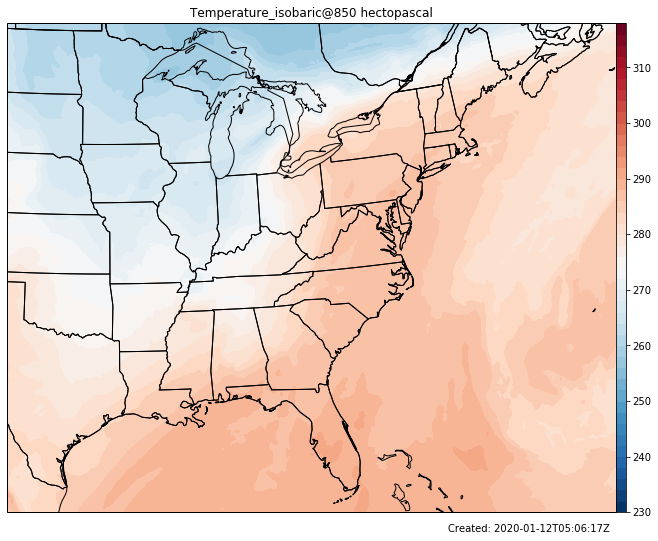

In [24]:
cfill = mpplots.FilledContourPlot()
cfill.time = datetime.utcnow()
cfill.data = model_ds
cfill.field = 'Temperature_isobaric'
cfill.level = 850 * units.hPa
cfill.colormap = 'RdBu_r'
cfill.contours = list(range(230, 320, 2))
cfill.colorbar = 'vertical'

# Plot the east coast 
panel = mpplots.MapPanel()
panel.area = 'east'
panel.layers = ['coastline', 'borders', 'states']
panel.plots = [cfill]

pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size=(15, 9)
mpplots.add_timestamp(panel.ax, time=start_time)
pc.show()

---
<a name="barbplot"></a>
### `BarbPlot` is useful for plotting wind barbs

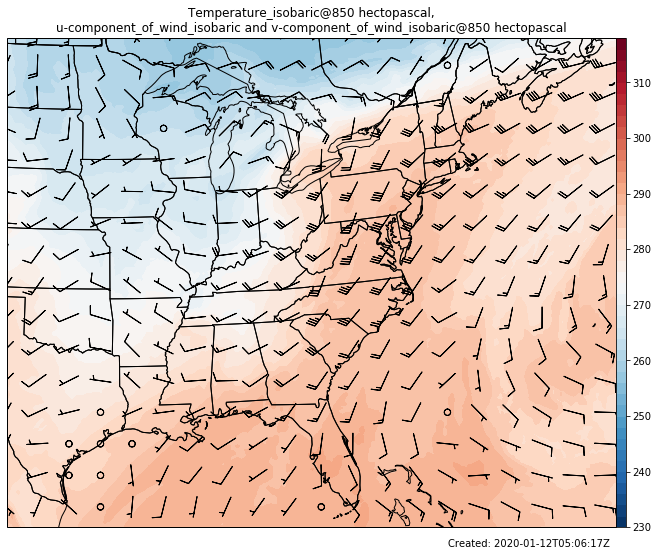

In [25]:
# Plot wind barbs
barb = mpplots.BarbPlot()
barb.time = datetime.utcnow()
barb.data = model_ds
barb.level = 850 * units.hPa
barb.field = ['u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']
barb.skip = (15, 15)
barb.color = 'black'
barb.barblength = 6.5
barb.earth_relative = False

# Use the same colorfill from the cells above
cfill = mpplots.FilledContourPlot()
cfill.time = datetime.utcnow()
cfill.data = model_ds
cfill.field = 'Temperature_isobaric'
cfill.level = 850 * units.hPa
cfill.colormap = 'RdBu_r'
cfill.contours = list(range(230, 320, 2))
cfill.colorbar = 'vertical'

# Plot the east coast 
panel = mpplots.MapPanel()
panel.area = 'east'
panel.layers = ['coastline', 'borders', 'states']
panel.plots = [cfill, barb]

pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size = (15, 9)
mpplots.add_timestamp(panel.ax, time=start_time)
pc.show()

---
<a name="combo"></a>
### Combine `PlotObs`, `ContourPlot`, and `ImagePlot` within a single `MapPanel`

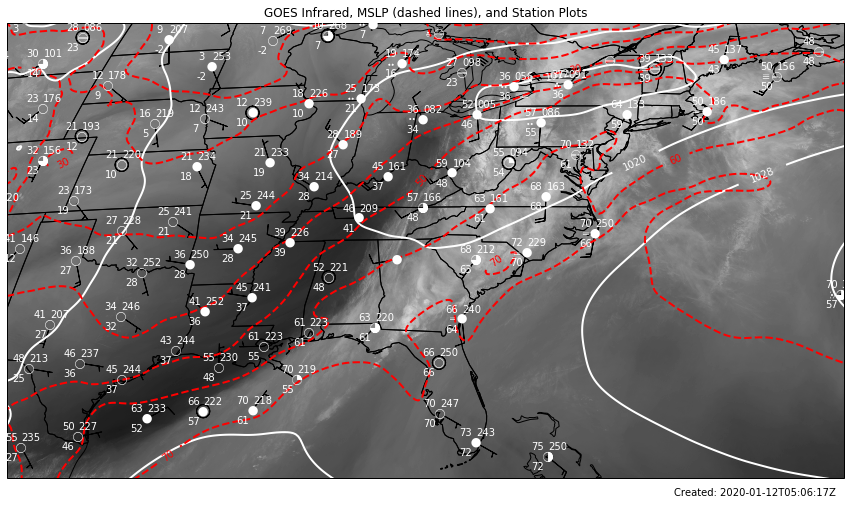

In [26]:
# Plot surface data
obs = mpplots.PlotObs()
obs.data = sfc_data
obs.level = None
obs.fields = ['air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level', 'cloud_coverage', 'present_weather', 'past_weather']
obs.locations = ['NW', 'SW', 'NE', 'C', 'W', 'SE']
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover',
               'current_weather', 'current_weather']
obs.colors = ['white', 'white', 'white', 'white', 'white', 'white']
obs.vector_field = ('eastward_wind', 'northward_wind')
obs.reduce_points = 1.8

# Setup ContourPlot for MSLP
contour_mslp = mpplots.ContourPlot()
contour_mslp.data = model_ds
contour_mslp.field = 'Pressure_reduced_to_MSL_msl'
contour_mslp.time = datetime.utcnow()
contour_mslp.level = None
contour_mslp.linecolor = 'white'
contour_mslp.clabels = True
contour_mslp.contours = list(range(900, 1100, 8))

# Setup another ContourPlot for temperature (in degrees Fahrenheit)
contour_temp = mpplots.ContourPlot()
contour_temp.data = model_ds
contour_temp.field = 'Temperature_height_above_ground'
contour_temp.time = datetime.utcnow()
contour_temp.linecolor = 'red'
contour_temp.linestyle = 'dashed'
contour_temp.clabels = True
contour_temp.contours = list(range(-50, 100, 10)) # Contour intervals

img = mpplots.ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'gray_r'
img.image_range = (195, 265)

panel = mpplots.MapPanel()
panel.layers = ['coastline', 'borders', 'states']
panel.area = 'east'
#panel.projection = 'lcc'
panel.plots = [img, contour_mslp, contour_temp, obs]
panel.title = 'GOES Infrared, MSLP (dashed lines), and Station Plots'

pc = mpplots.PanelContainer()
pc.panels = [panel]
pc.size=(15, 9)
mpplots.add_timestamp(panel.ax, time=start_time)
pc.show()